In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
# import textblob
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import string
import re
import spacy
import gensim
import warnings
warnings.filterwarnings("ignore")

### **Plan of Action**

1. Load data
2. EDA
3. Feature engineering
4. Topic modelling
    - Top2Vec
5. Repeat step 4

In [2]:
df = pd.read_csv('../topic_data.csv')

In [3]:
df_copy = df.copy()
df_copy.describe()

raw_text_length    year        month  cleaned_text_length
count      4568.000000  4568.0  4568.000000          4568.000000
mean         27.330560  2023.0     3.703590            24.769483
std          11.840659     0.0     0.456724            11.581002
min           1.000000  2023.0     3.000000             1.000000
25%          17.000000  2023.0     3.000000            15.000000
50%          27.000000  2023.0     4.000000            24.000000
75%          37.000000  2023.0     4.000000            34.000000
max          61.000000  2023.0     4.000000            57.000000

In [4]:
df_copy.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568 entries, 0 to 4567
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 4568 non-null   object
 1   date                 4568 non-null   object
 2   raw_text_length      4568 non-null   int64 
 3   year                 4568 non-null   int64 
 4   month                4568 non-null   int64 
 5   cleaned_text         4568 non-null   object
 6   cleaned_text_length  4568 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 3.2 MB


**Memory management**

In [5]:
# Memory management
def memory_magment(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != np.object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8) # int 8
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16) # int 16
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)  # in 32
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) # int 64 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else: 
                    df[col] = df[col].astype(np.float64)
    return df
df_memory = df_copy.copy()
df_memory = memory_magment(df_memory)    

In [6]:
df_memory.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568 entries, 0 to 4567
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 4568 non-null   object
 1   date                 4568 non-null   object
 2   raw_text_length      4568 non-null   int8  
 3   year                 4568 non-null   int16 
 4   month                4568 non-null   int8  
 5   cleaned_text         4568 non-null   object
 6   cleaned_text_length  4568 non-null   int8  
dtypes: int16(1), int8(3), object(3)
memory usage: 3.1 MB


In [7]:
featured_data = df_memory[['text']]

In [8]:
featured_data

text
0     "Ah, yes. I just love waking up to the sweet a...
1     When @ViolavonCramon\nflies to Georgia 🇬🇪 to t...
2     Exclusive — Rep. Jeff Van Drew: Democrats Afra...
3     It’s April 03, 2023 at 12:29PM\nStop Your Peri...
4     #PMAtCBIDiamondJubilee\nCorruption and dynasti...
...                                                 ...
4563  If the Word cannot provoke you to preach the g...
4564  cept\nmy own and that of the manager.\n\n"'My ...
4565  Graham Potter's Chelsea exit set for huge impa...
4566  How to watch Manchester United vs Brentford - ...
4567  Erik ten Hag has contradicted himself over Wou...

[4568 rows x 1 columns]

In [9]:
docs = featured_data['text'].tolist()

In [10]:
docs[0]

'"Ah, yes. I just love waking up to the sweet aroma of political chaos and corruption in the morning. It\'s like a breath of fresh air...if that air was filled with hot garbage." #politics #sarcasm'

### **Top2Vec**

In [11]:
from top2vec import Top2Vec

Top2Vec takes care of the preprocessing for us.

In [12]:
model = Top2Vec(docs, embedding_model="doc2vec",workers=2,ngram_vocab=True,speed="deep-learn")  
# Using bigrams
# doc2vec & fast-learn" is used by default

2023-04-17 09:35:53,407 - top2vec - INFO - Pre-processing documents for training
2023-04-17 09:35:55,695 - top2vec - INFO - Creating joint document/word embedding
2023-04-17 09:40:29,873 - top2vec - INFO - Creating lower dimension embedding of documents
2023-04-17 09:41:44,695 - top2vec - INFO - Finding dense areas of documents
2023-04-17 09:41:45,486 - top2vec - INFO - Finding topics


**Get Number of Topics**

In [13]:
model.get_num_topics()

46

In [14]:
len(model.vocab)

1024

This will return the number of topics that Top2Vec has found in the data.

**Get Topic Sizes**

In [15]:
topic_sizes, topic_nums = model.get_topic_sizes()

This will return the number of documents most similar to each topic. Topics are in decreasing order of size.

In [16]:
topic_sizes # The number of documents most similar to each topic.

array([578, 320, 161, 149, 133, 125, 117, 116, 114, 112, 111, 107, 106,
       103, 103, 101,  99,  98,  94,  87,  86,  79,  79,  78,  77,  77,
        72,  71,  69,  69,  69,  67,  66,  66,  65,  60,  56,  54,  54,
        53,  52,  46,  45,  45,  42,  37], dtype=int64)

In [17]:
topic_nums # 46 topics
# The unique index of every topic will be returned

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

37 documents are related to topic index 45.

**Get Topics**

This will return the topics in decreasing size.

In [18]:
topic_words, word_scores, topic_nums = model.get_topics(10) # n_topics

**topic_words:** For each topic the top 50 words are returned, in order of semantic similarity to topic.

**word_scores:** For each topic the cosine similarity scores of the top 50 words to the topic are returned.

**topic_nums:** The unique index of every topic will be returned.


They are all arrays/list values

In [20]:
# topic_nums
# [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
# 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
# 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

for words, scores, topic in zip(topic_words, word_scores, topic_nums):
    print(f"Topic: {topic}\nWords: {words} ")

Topic: 0
Words: ['machinelearning' 'ai' 'technology' 'innovation' 'datascience'
 'healthtech' 'patient' 'industry' 'python' 'data' 'ml' 'healthcare'
 'chatgpt' 'transforming' 'tech' 'potential' 'intelligence'
 'transforming healthcare' 'artificial' 'learn' 'learning' 'machine'
 'using' 'ai ml' 'digitalhealth' 'future' 'health' 'ml models' 'ml tools'
 'transforming industries' 'tech data' 'patient outcomes'
 'improve patient' 'digital' 'tech technology' 'is transforming' 'science'
 'education' 'care' 'medtech' 'medicine' 'research' 'healthcare plans'
 'patient care' 'ai innovation' 'healthcare providers' 'more here'
 'healthcare healthtech' 'healthcare industry' 'more'] 
Topic: 1
Words: ['even' 'still' 'they' 'but' 'going' 'be' 'want' 'right' 'when' 'election'
 'never' 'because' 'because they' 'there' 'see' 'so' 'only' 'why'
 'nigeria' 'would' 'back' 'go' 'these' 'they want' 'party' 'years' 'last'
 'him' 'that' 'country' 'many' 'do' 'any' 'who' 'media' 'have' 'know'
 'because we' 'messi

**Search Topics**

We are going to search for topics most similar to healthcare.

In [22]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["healthcare"], num_topics=10)

**topic_words:** For each topic the top 50 words are returned, in order of semantic similarity to topic.

**word_scores:** For each topic the cosine similarity scores of the top 50 words to the topic are returned.

**topic_scores:** For each topic the cosine similarity to the search keywords will be returned.

**topic_nums:** The unique index of every topic will be returned.

In [24]:
for words, word_scores, topic_score, topic in zip(topic_words, word_scores, topic_scores, topic_nums):
    print(f"Topic: {topic}, Score:{topic_score}\nWords: {words}\n")

Topic: 0, Score:0.630807481732256
Words: ['machinelearning' 'ai' 'technology' 'innovation' 'datascience'
 'healthtech' 'patient' 'industry' 'python' 'data' 'ml' 'healthcare'
 'chatgpt' 'transforming' 'tech' 'potential' 'intelligence'
 'transforming healthcare' 'artificial' 'learn' 'learning' 'machine'
 'using' 'ai ml' 'digitalhealth' 'future' 'health' 'ml models' 'ml tools'
 'transforming industries' 'tech data' 'patient outcomes'
 'improve patient' 'digital' 'tech technology' 'is transforming' 'science'
 'education' 'care' 'medtech' 'medicine' 'research' 'healthcare plans'
 'patient care' 'ai innovation' 'healthcare providers' 'more here'
 'healthcare healthtech' 'healthcare industry' 'more']

Topic: 17, Score:0.5546840346375619
Words: ['medicine' 'medtech' 'digitalhealth' 'health' 'tech' 'uk' 'digital'
 'genetics medicine' 'telemedicine medicine' 'digital health'
 'medtech ehealth' 'medicaltech medtech' 'digital hacking'
 'digital transformation' 'may' 'medicine ai' 'digitalhealth he

Topics 0 and 17 are highly related to healthcare

**Search Documents by Topic**

We are going to search by topic 0. i.e. Documents similar to topic 0.

**documents:** The documents in a list, the most similar are first.

**doc_scores:** Semantic similarity of document to topic. The cosine similarity of the document and topic vector.

**doc_ids:** Unique ids of documents. If ids were not given, the index of document in the original corpus

In [26]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=0, num_docs=5)

In [27]:
for doc, score, doc_id in zip(documents,document_scores,document_ids):
    print(f"Document: {doc_id}, Score relationship to  topic 0: {score}")
    print("-----------")
    print(doc)
    print("-----------\n")

Document: 1666, Score relationship to  topic 0: 0.7986933588981628
-----------
#ai #ml #artificialintelligence #machinelearning #datascience #bigdata #analytics #blockchain #tech #data @Nicochan33 @TrippBraden @Paula_Piccard @haroldsinnott @sallyeaves
Planning A Data Strategy For Training Healthcare AI Applications https://t.co/z2XsfvXQqS
-----------

Document: 2059, Score relationship to  topic 0: 0.7894405722618103
-----------
#Artificialintelligence develops #cancer treatment in just 30 days https://t.co/6pQZ1oSPvV #bigdata #deeplearning #AI #DL #ML #Healthcare #python #healthtech #MachineLearning #deeplearning #NLP #rstats #innovation #techforgood #Data #tech #DataScience #technology @DailyMailUK
-----------

Document: 1890, Score relationship to  topic 0: 0.7783349752426147
-----------
Guiding principles for the responsible development of #ArtificialIntelligence tools for #healthcare 

#AI #HealthTech #MedicalTech #MedTech #ML #MachineLearning #DeepLearning #DL #Tech #Technology #

Topic 0 is related to healthcare and AI which goes to show that the above documents; 1666, 2059, 1890, 2499, 2064 are highly related to topic 0.

**Semantic Search Documents by Keywords**

Search documents for content semantically similar to machine learning, Data science and healthcare.

In [30]:
documents, document_scores, document_ids = (model.
                                search_documents_by_keywords
                                # (keywords=["machine",'learning'], num_docs=5))
                                (keywords=["machine learning", "Data science","healthcare"], num_docs=10))

In [31]:
for doc, score, doc_id in zip(documents,document_scores,document_ids):
    print(f"Document: {doc_id}\nScore relationship the keywords: {score}")
    print("-----------")
    print(doc)
    print("-----------\n")

Document: 1823
Score relationship the keywords: 0.8431230187416077
-----------
🐍 Python libraries for data science:

• NumberCrunch (math)
• OpenPyXL (excel manipulation)
• TensorFlow (machine learning)
• Numpy (multi-dimensional arrays)
• Pandas (data manipulation)
• OpenCV (computer vision)
• PyTorch (machine learning framework)

#ai #python https://t.co/8I66vaBB1l
-----------

Document: 1968
Score relationship the keywords: 0.8346226215362549
-----------
SevenMentor | AI | Data Science | Machine Learning classes on Google: https://t.co/9E8uRkU8Ah
-----------

Document: 1843
Score relationship the keywords: 0.8313820362091064
-----------
2023-04-02:Data Science, Machine Learning, Cloud, Cybersecurity Opportunities https://t.co/9tTJY1dOnM
-----------

Document: 1970
Score relationship the keywords: 0.8131039142608643
-----------
Beginning Mathematica and Wolfram for Data Science: Applications in Data Analysis, Machine Learning, and Neural Networks AD2AFW8

https://t.co/tBbSjwhDRD
----

The above documents namely; 1823, 1968, 18843, 1970, 2100, 1993, 2500, 1905, 1867 and 1945 are semantically similar the words machine learning, Data science and healthcare.

**Similar Keywords**

Search semantic similarity search of words relating to healthcare.

In [33]:
words, word_scores = model.similar_words(keywords=["healthcare"], keywords_neg=[], num_words=20)

In [34]:
for word, score in zip(words, word_scores):
    print(f"Word: {word}, Score: {score}")

Word: ai, Score: 0.8749192404530353
Word: technology, Score: 0.8188382921863225
Word: innovation, Score: 0.7933856577080753
Word: tech, Score: 0.7150173415741915
Word: patient, Score: 0.7051274375914527
Word: potential, Score: 0.7023372677463238
Word: health, Score: 0.688297026805265
Word: education, Score: 0.6879677317545622
Word: transforming, Score: 0.6811317435623438
Word: industry, Score: 0.6780100020203105
Word: machinelearning, Score: 0.6762663722052469
Word: healthtech, Score: 0.6502199803671401
Word: digitalhealth, Score: 0.6413248504216484
Word: future, Score: 0.6361570294445158
Word: datascience, Score: 0.6316078009400323
Word: medtech, Score: 0.6229358594389989
Word: chatgpt, Score: 0.6144972182638286
Word: ml, Score: 0.6118904729994739
Word: medicine, Score: 0.599796754365095
Word: digital, Score: 0.5780985110514373


**Semantic similarity search of documents.**

The most semantically similar documents to the semantic combination of document ids provided will be returned. If negative document ids are provided, the documents will be semantically dissimilar to those document ids. Documents will be ordered by decreasing similarity. This method finds the closest document vectors to the provided documents averaged.

In [35]:
documents, doc_scores, doc_ids = (model.
                                search_documents_by_documents(
                                    doc_ids=[0],
                                    num_docs=5,
                                    # ef=2
                                ))

In [37]:
print(f"Document at index 0\n{featured_data.text[0]}\n")
for doc, score, doc_id in zip(documents,doc_scores,doc_ids):
    print(f"Document: {doc_id}\nScore relationship document at index 0: {score}")
    print("-----------")
    print(doc)
    print("-----------\n")

Document at index 0
"Ah, yes. I just love waking up to the sweet aroma of political chaos and corruption in the morning. It's like a breath of fresh air...if that air was filled with hot garbage." #politics #sarcasm

Document: 697
Score relationship document at index 0: 0.7253257632255554
-----------
The L.A. City Council has a number of options when it comes to replacing Mark Ridley-Thomas, who was convicted on felony corruption charges. 

https://t.co/URiKOkEBFK
-----------

Document: 699
Score relationship document at index 0: 0.7133089900016785
-----------
The L.A. City Council has a number of options when it comes to replacing Mark Ridley-Thomas, who was convicted on felony corruption charges. 

https://t.co/XFkHw5DVLL
-----------

Document: 3637
Score relationship document at index 0: 0.6758135557174683
-----------
Jack Wilshere's 'deep love for football' has returned after taking charge of Arsenal's Under 18s https://t.co/30saVmxZ1O
-----------

Document: 570
Score relationship 

THe above documents are related to document 0 from the dataset.

**Generate Word Clouds**

Using a topic number you can generate a word cloud. We are going to generate word clouds for the top 5 most similar topics to our healthcare topic search from above.

In [38]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["healthcare"], num_topics=10)

In [39]:
len(topic_nums)

10

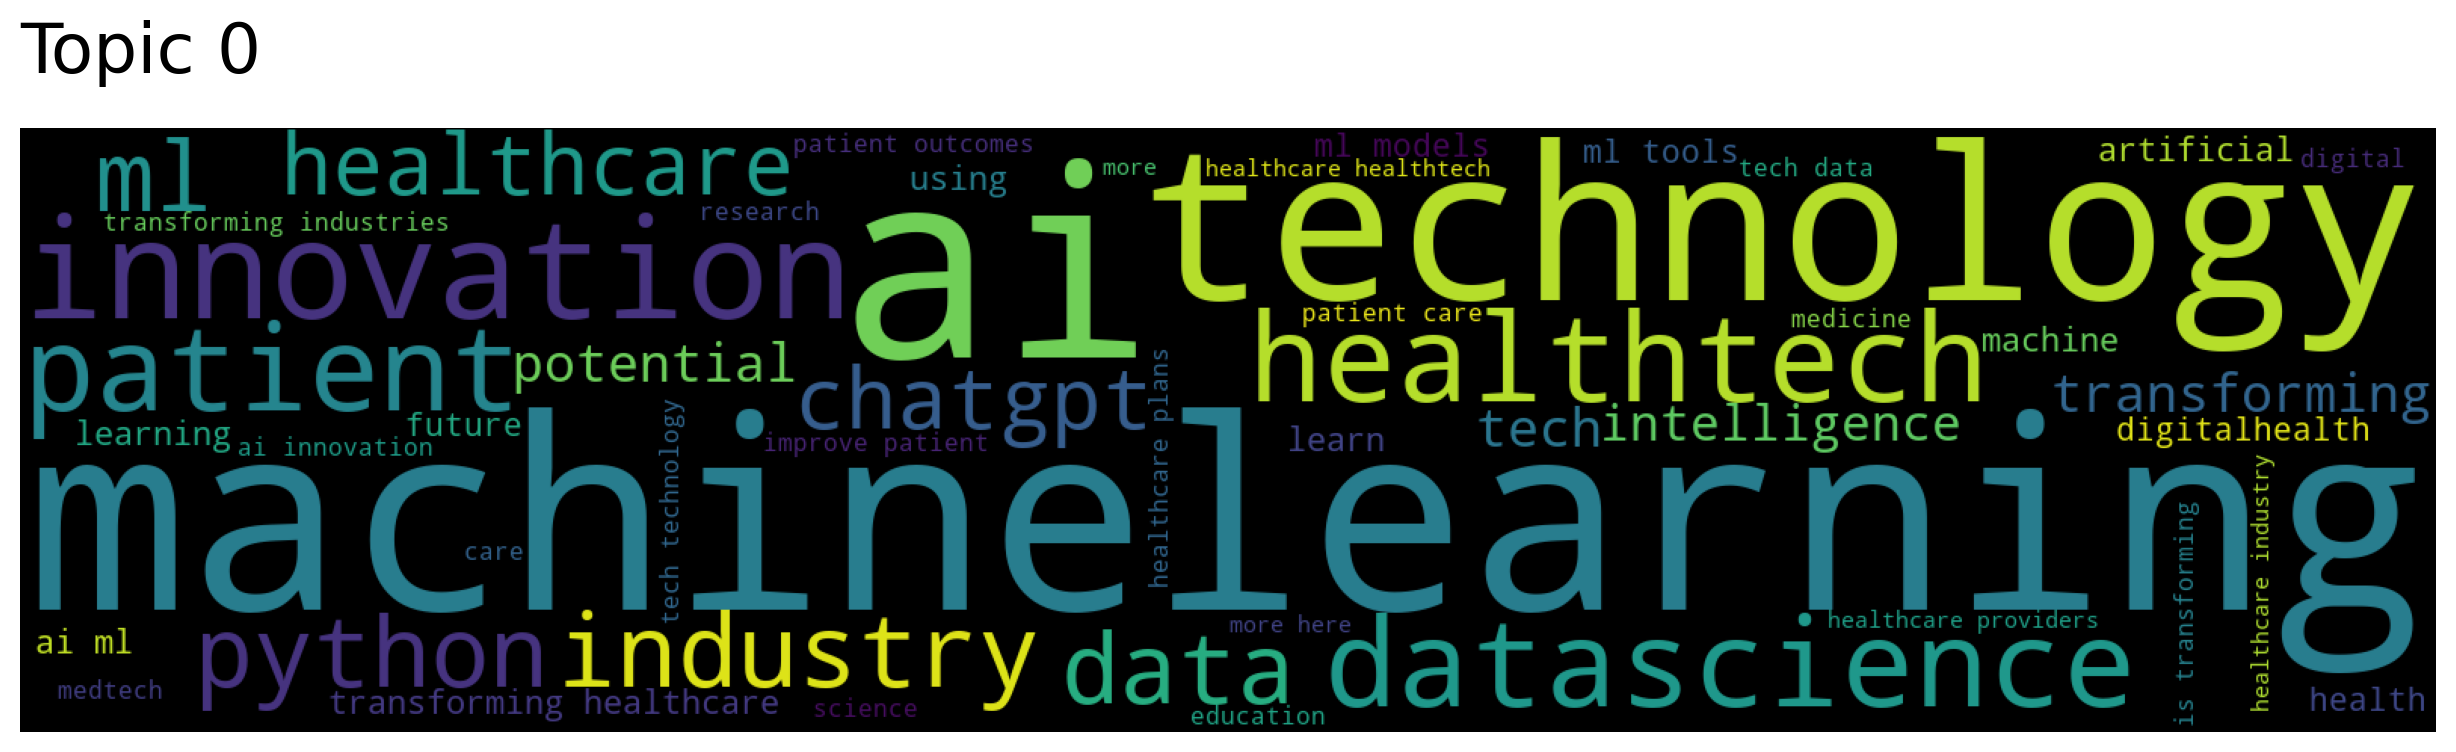

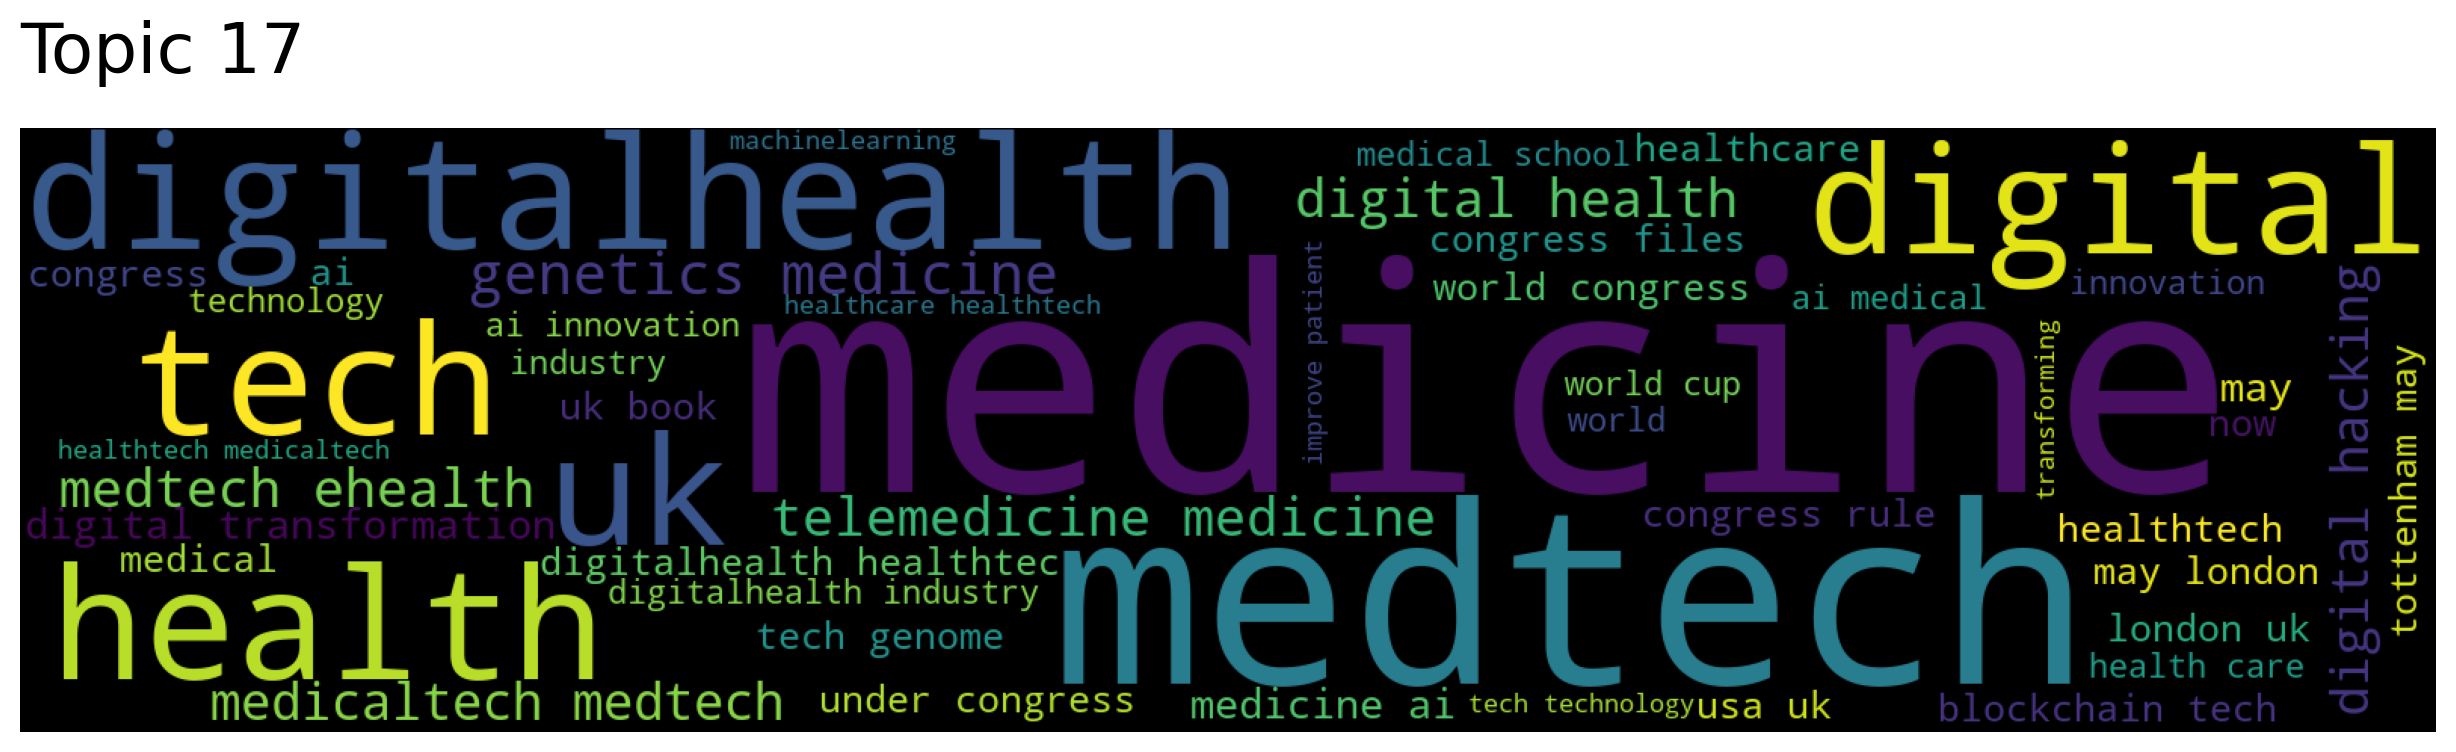

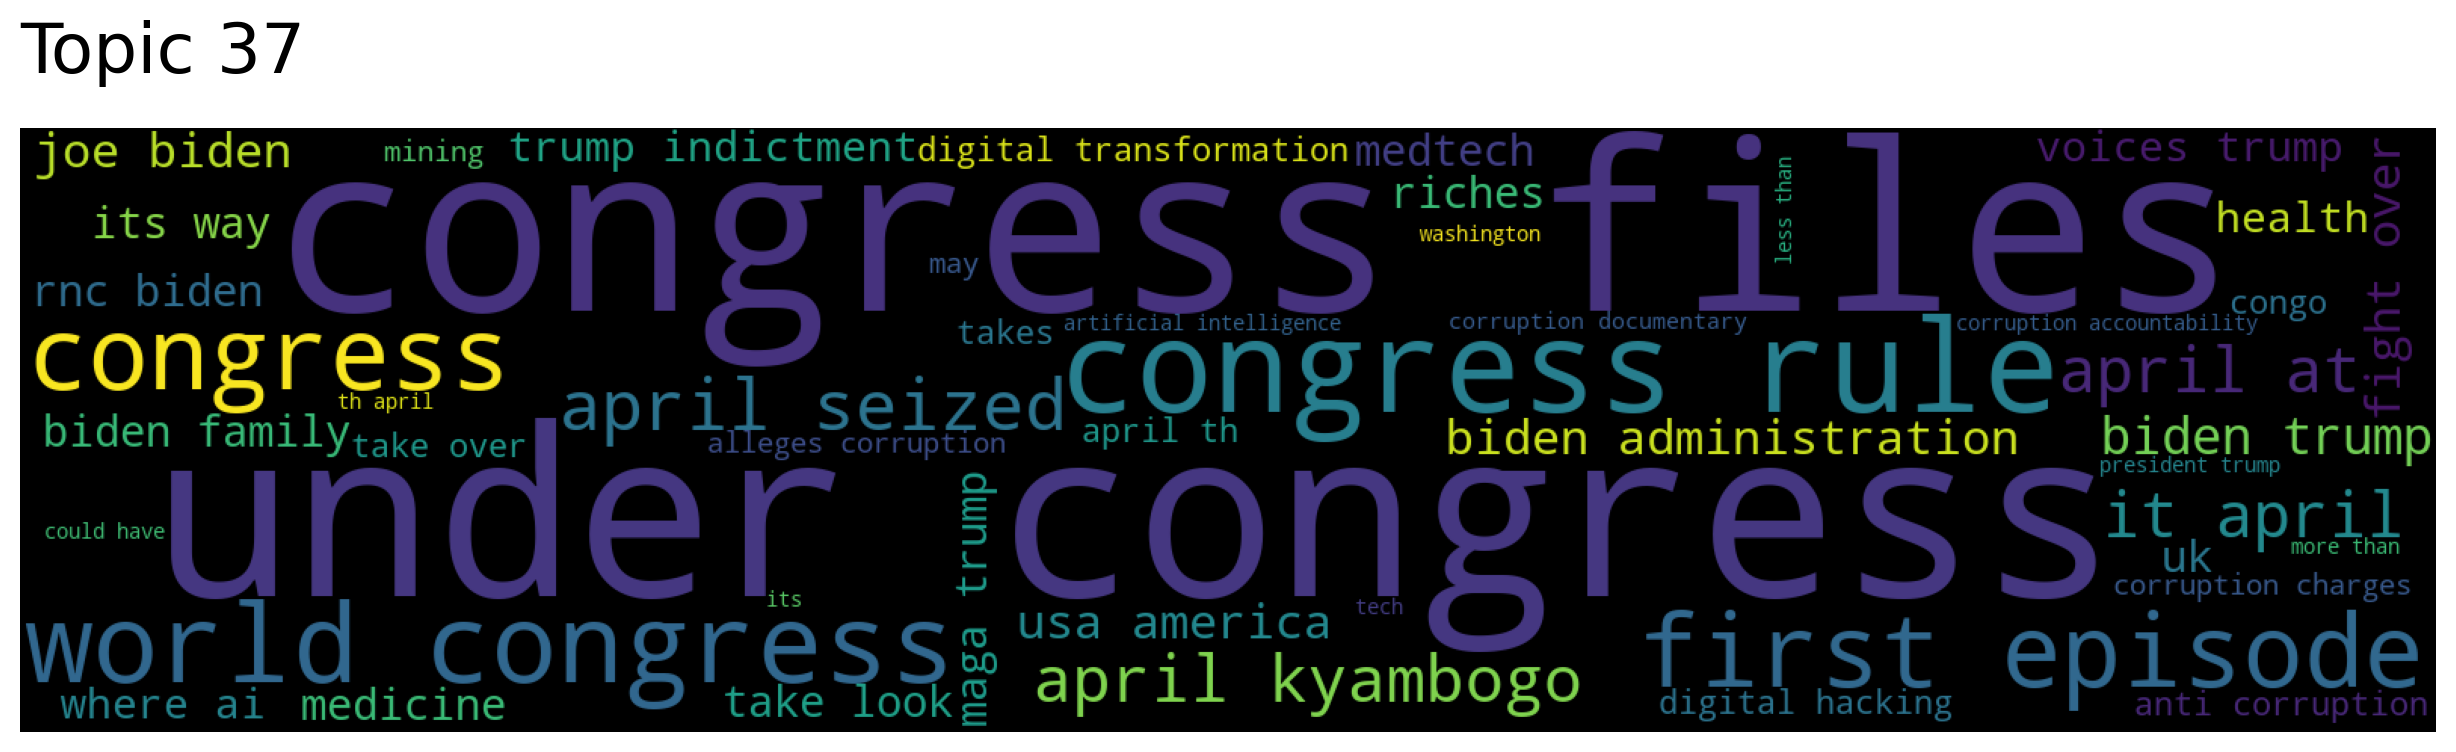

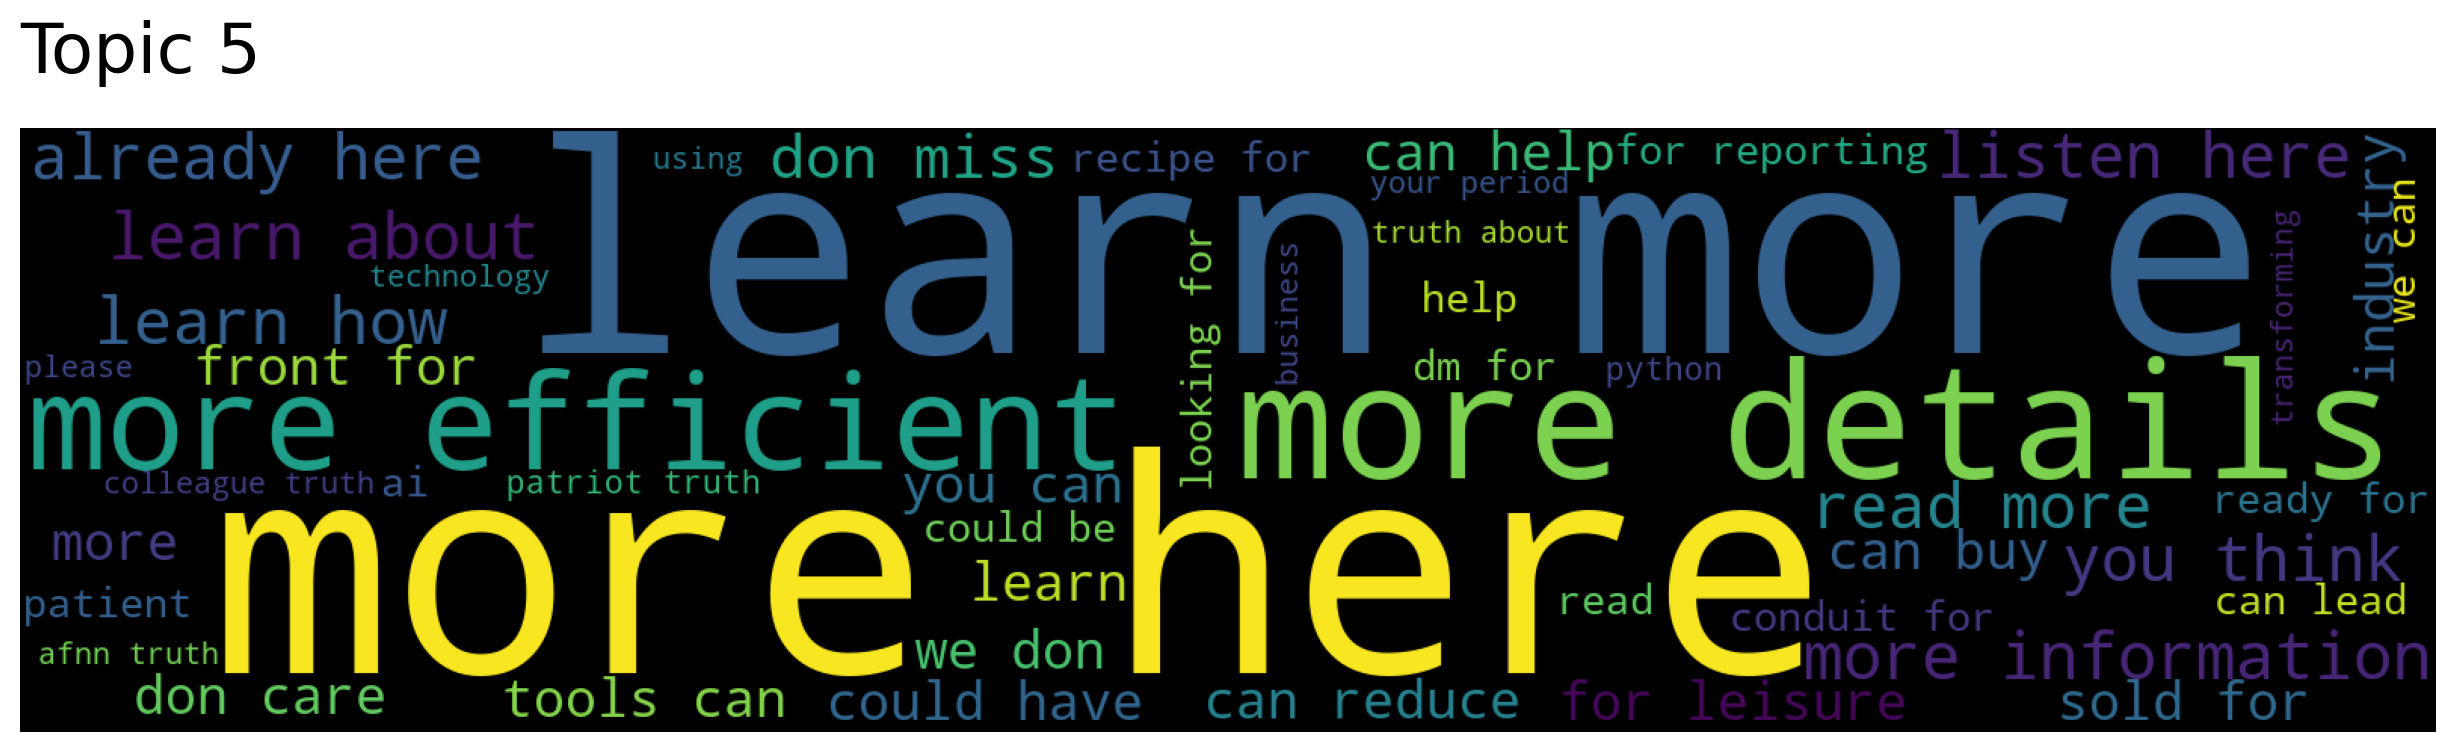

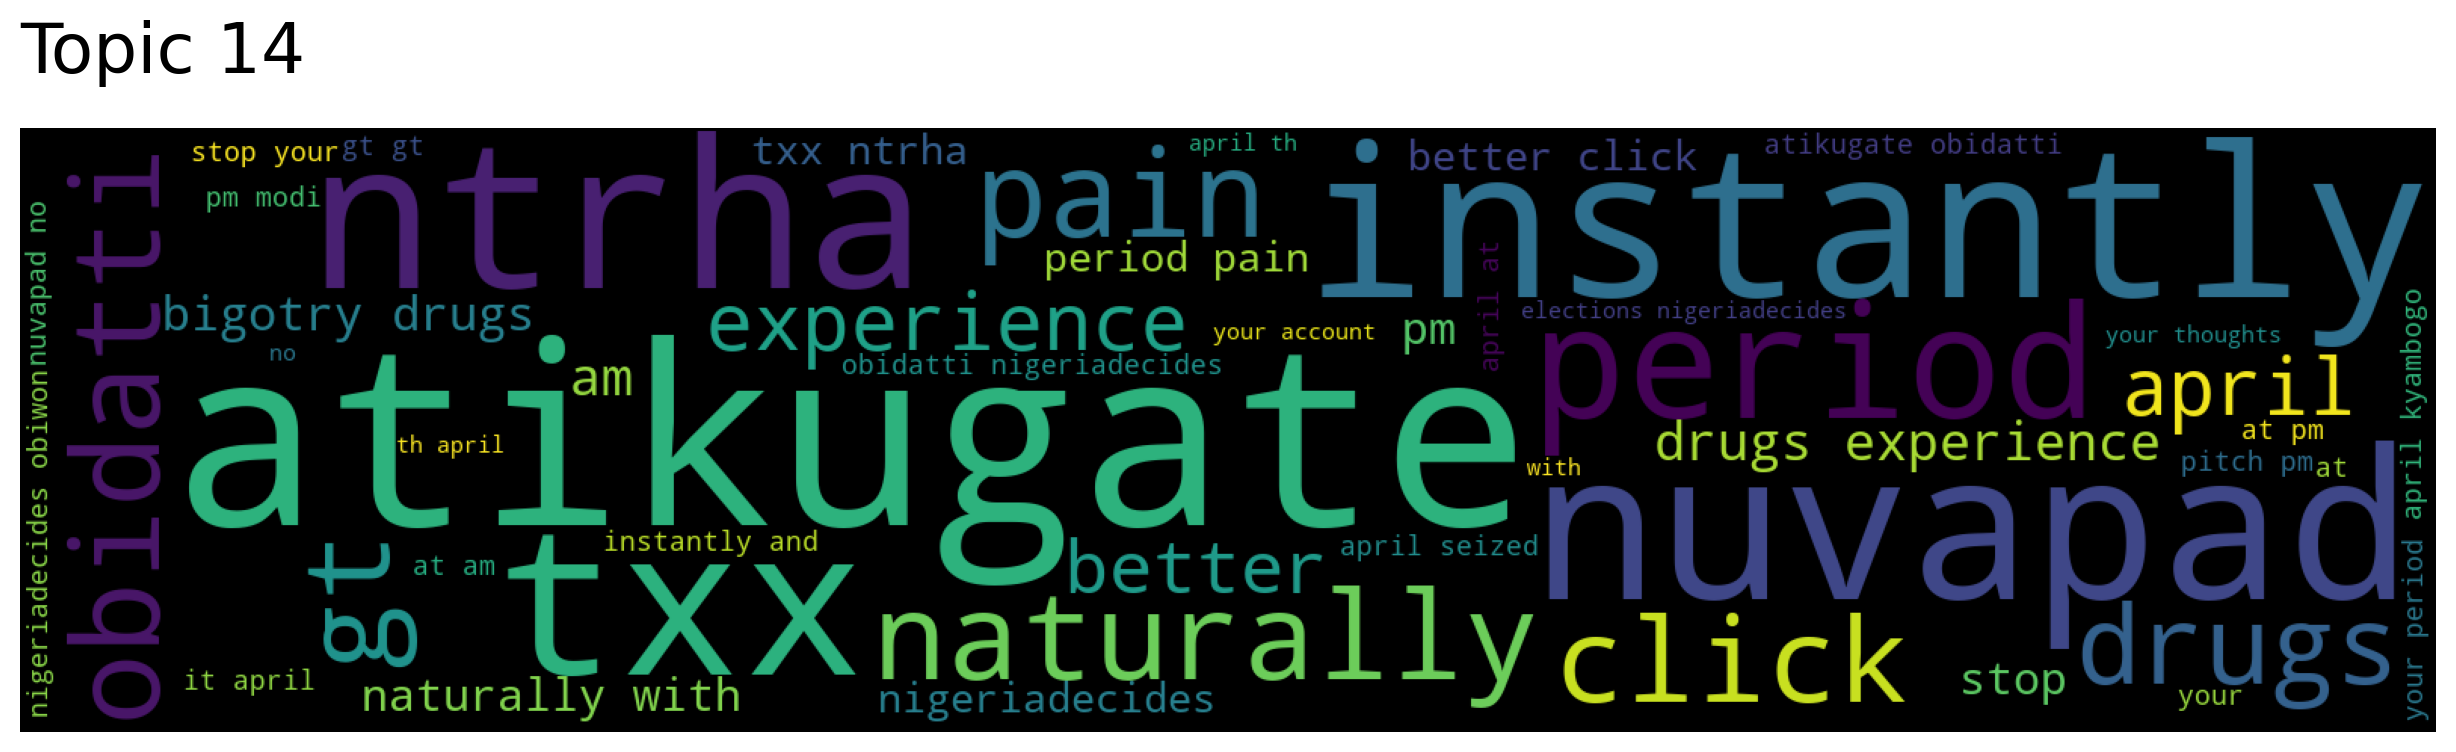

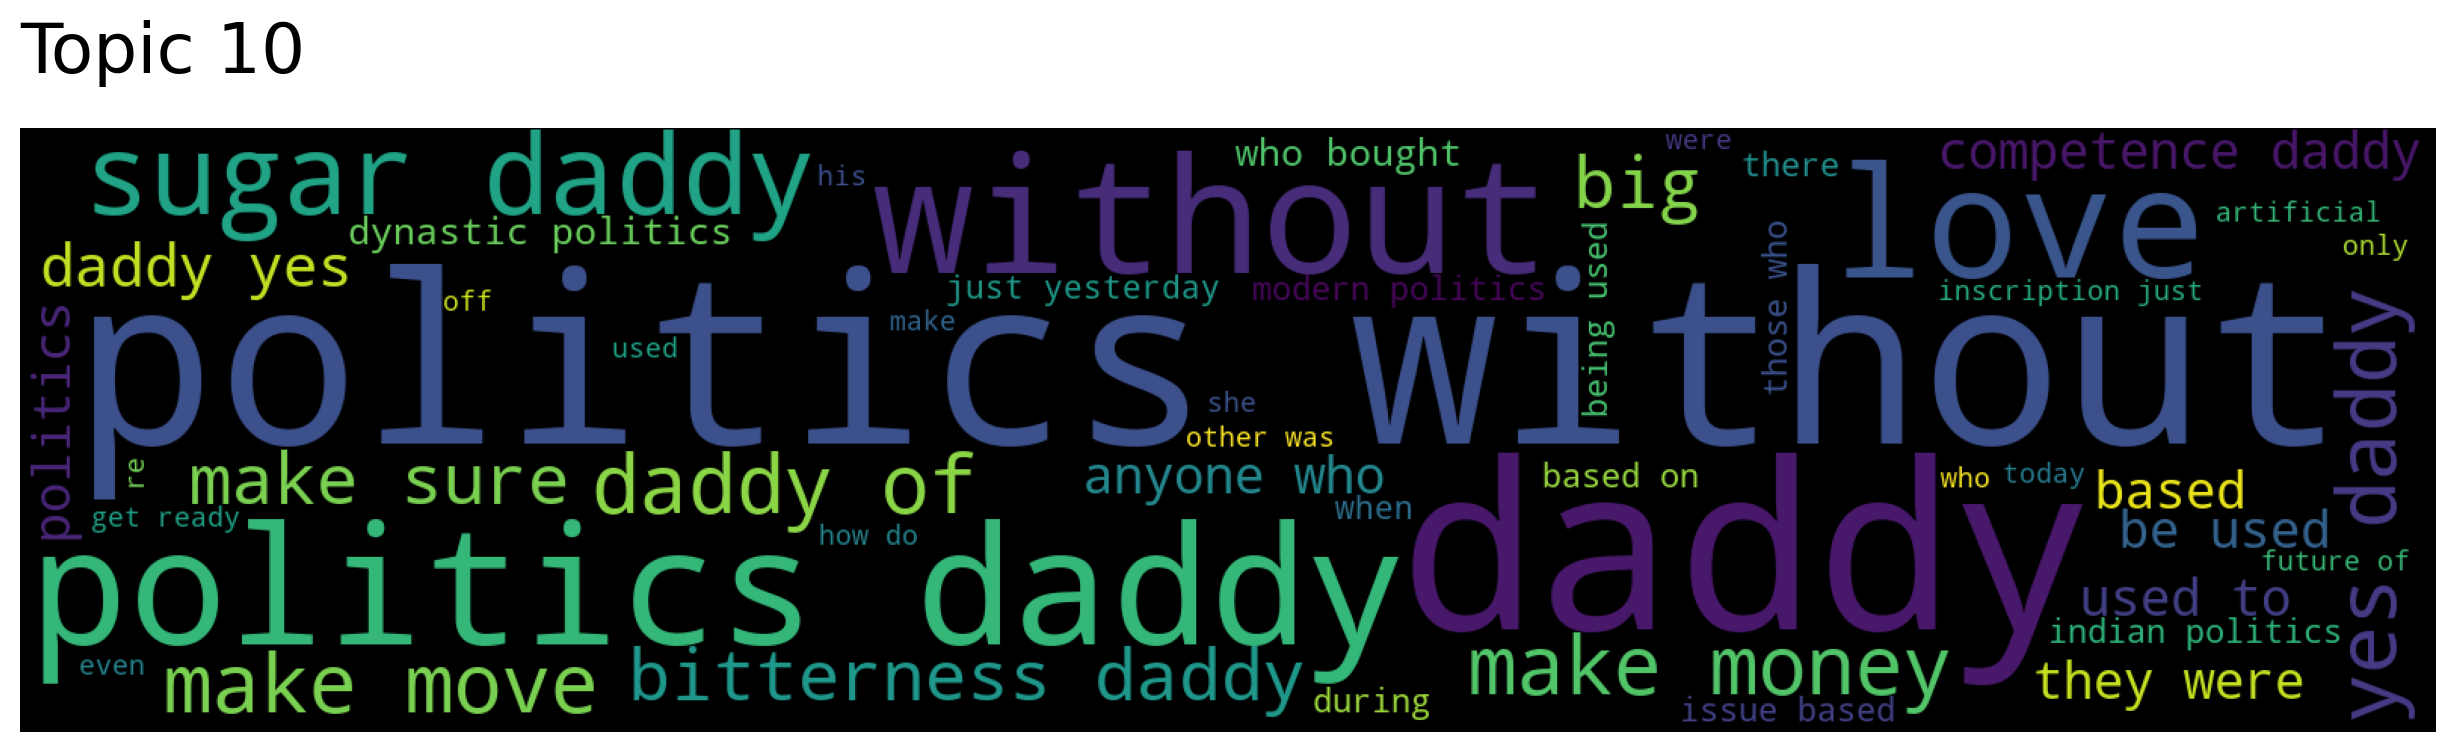

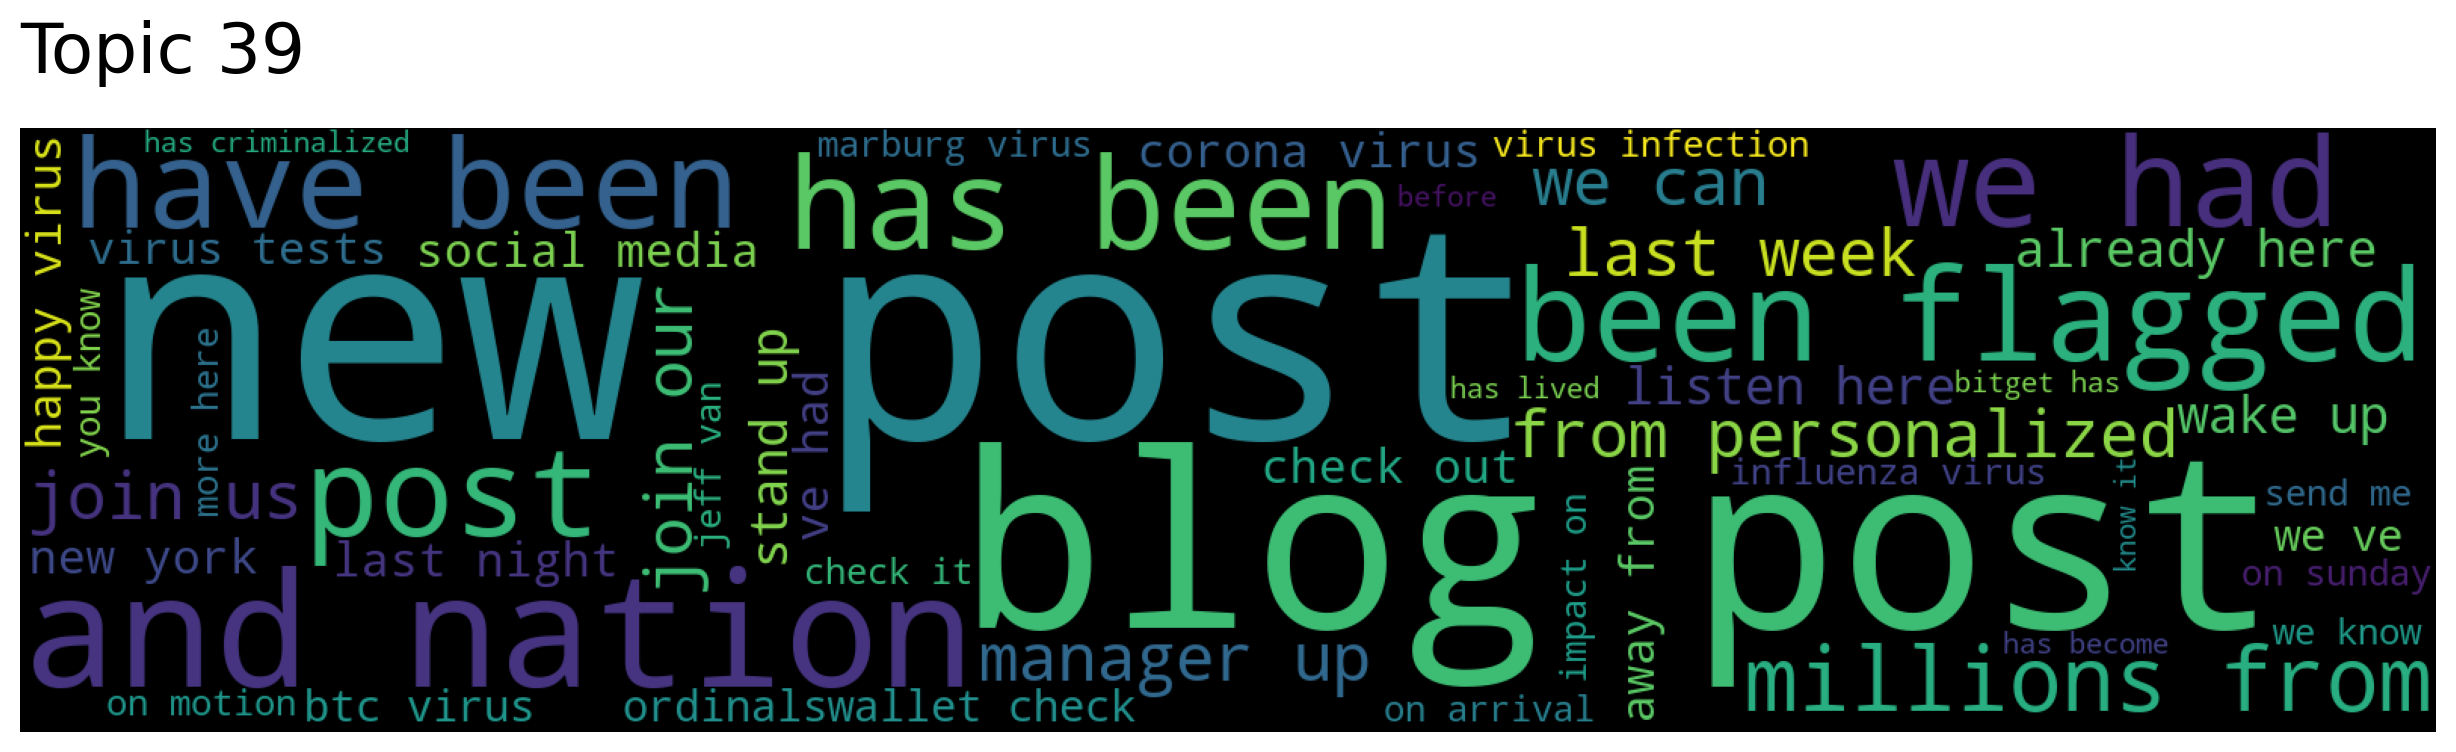

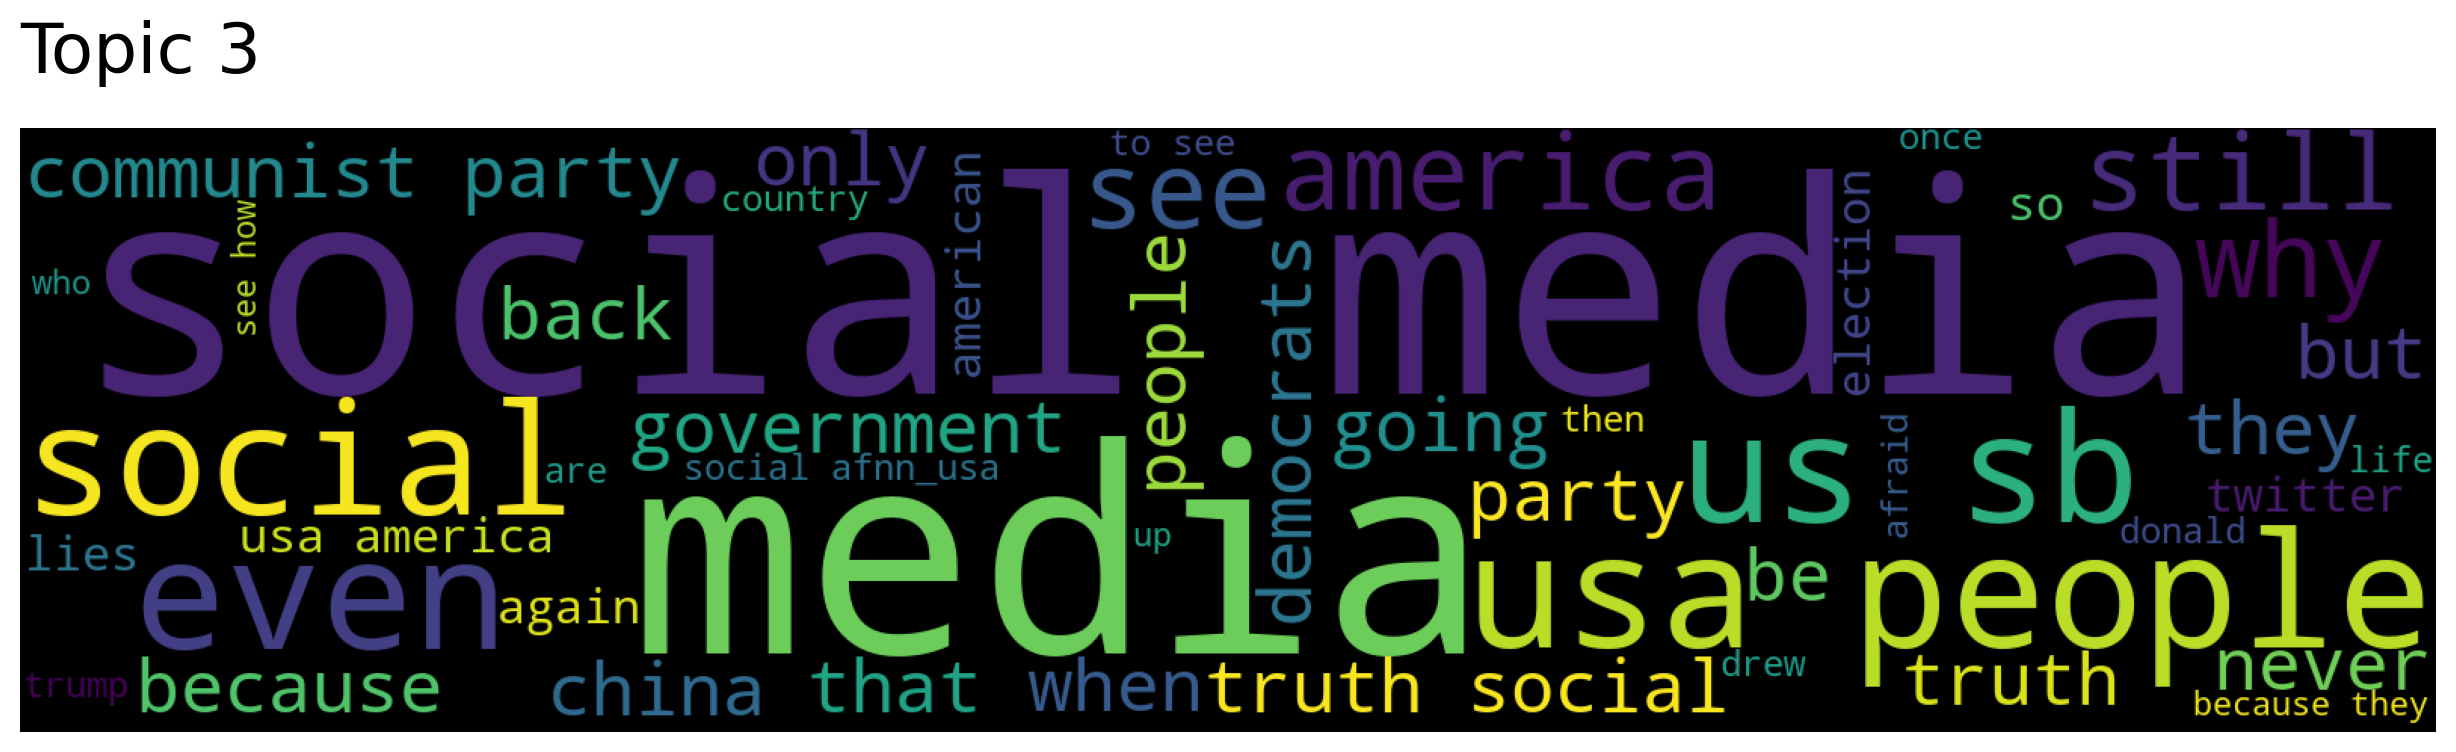

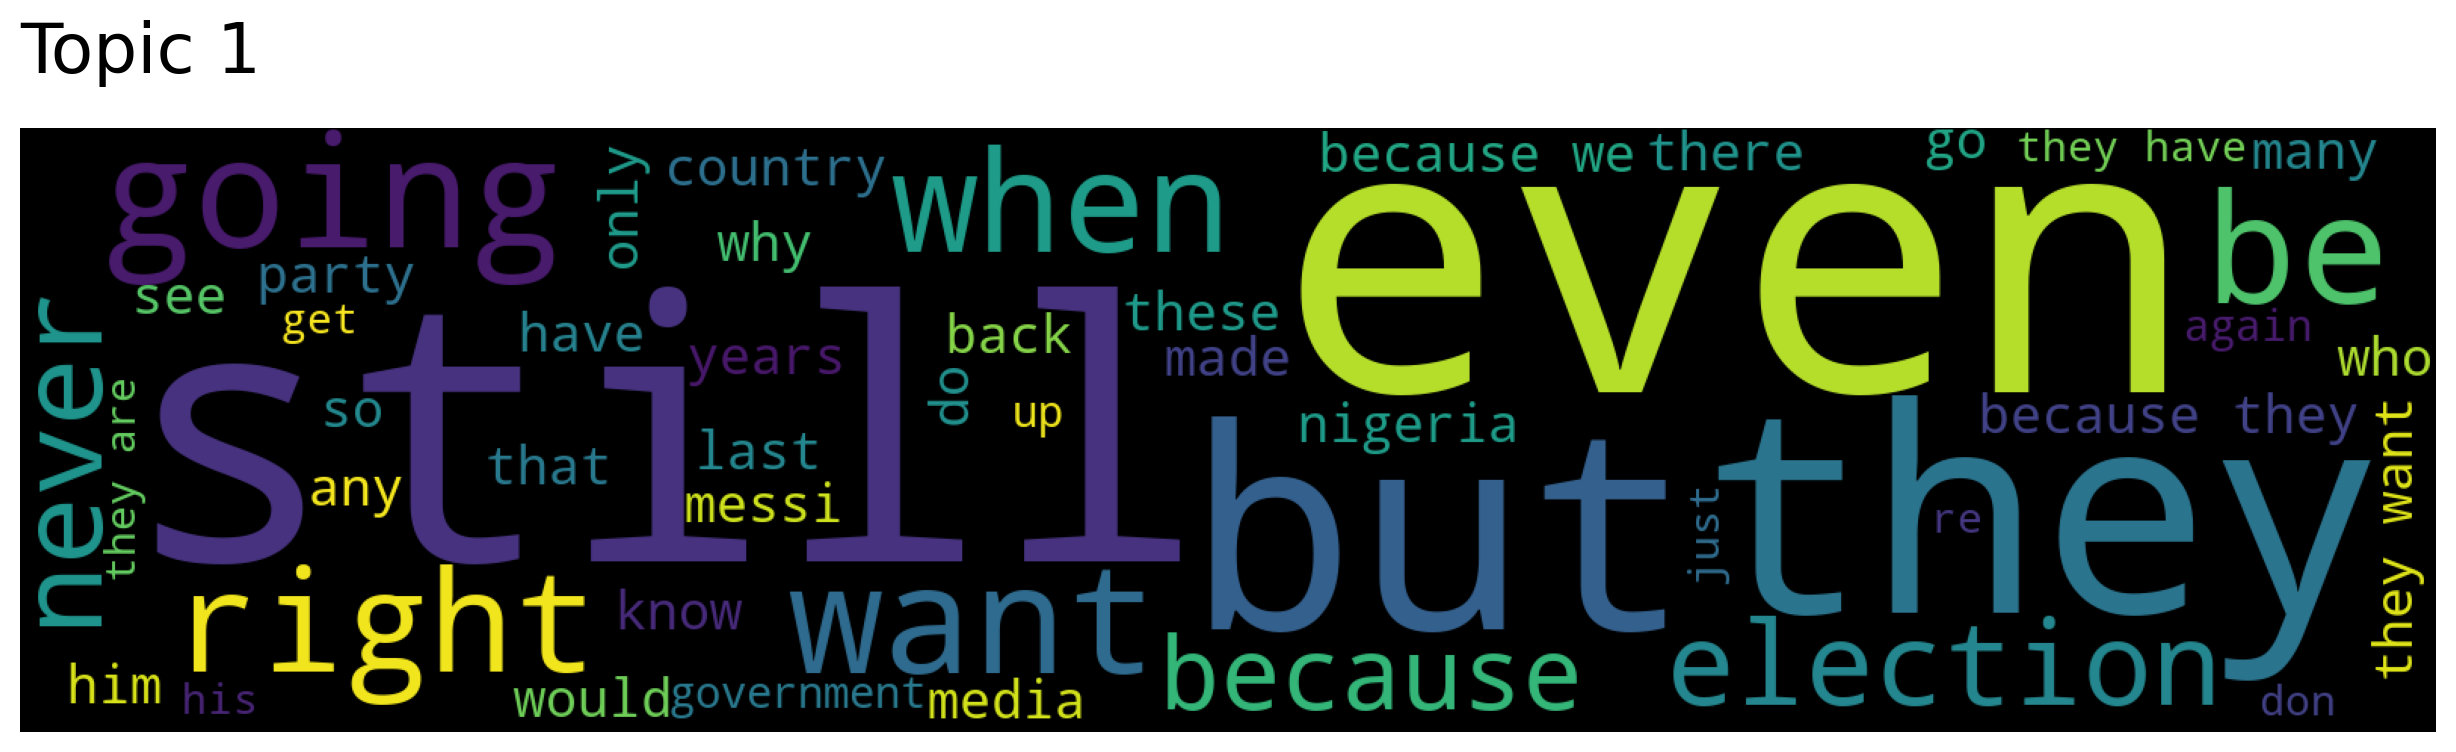

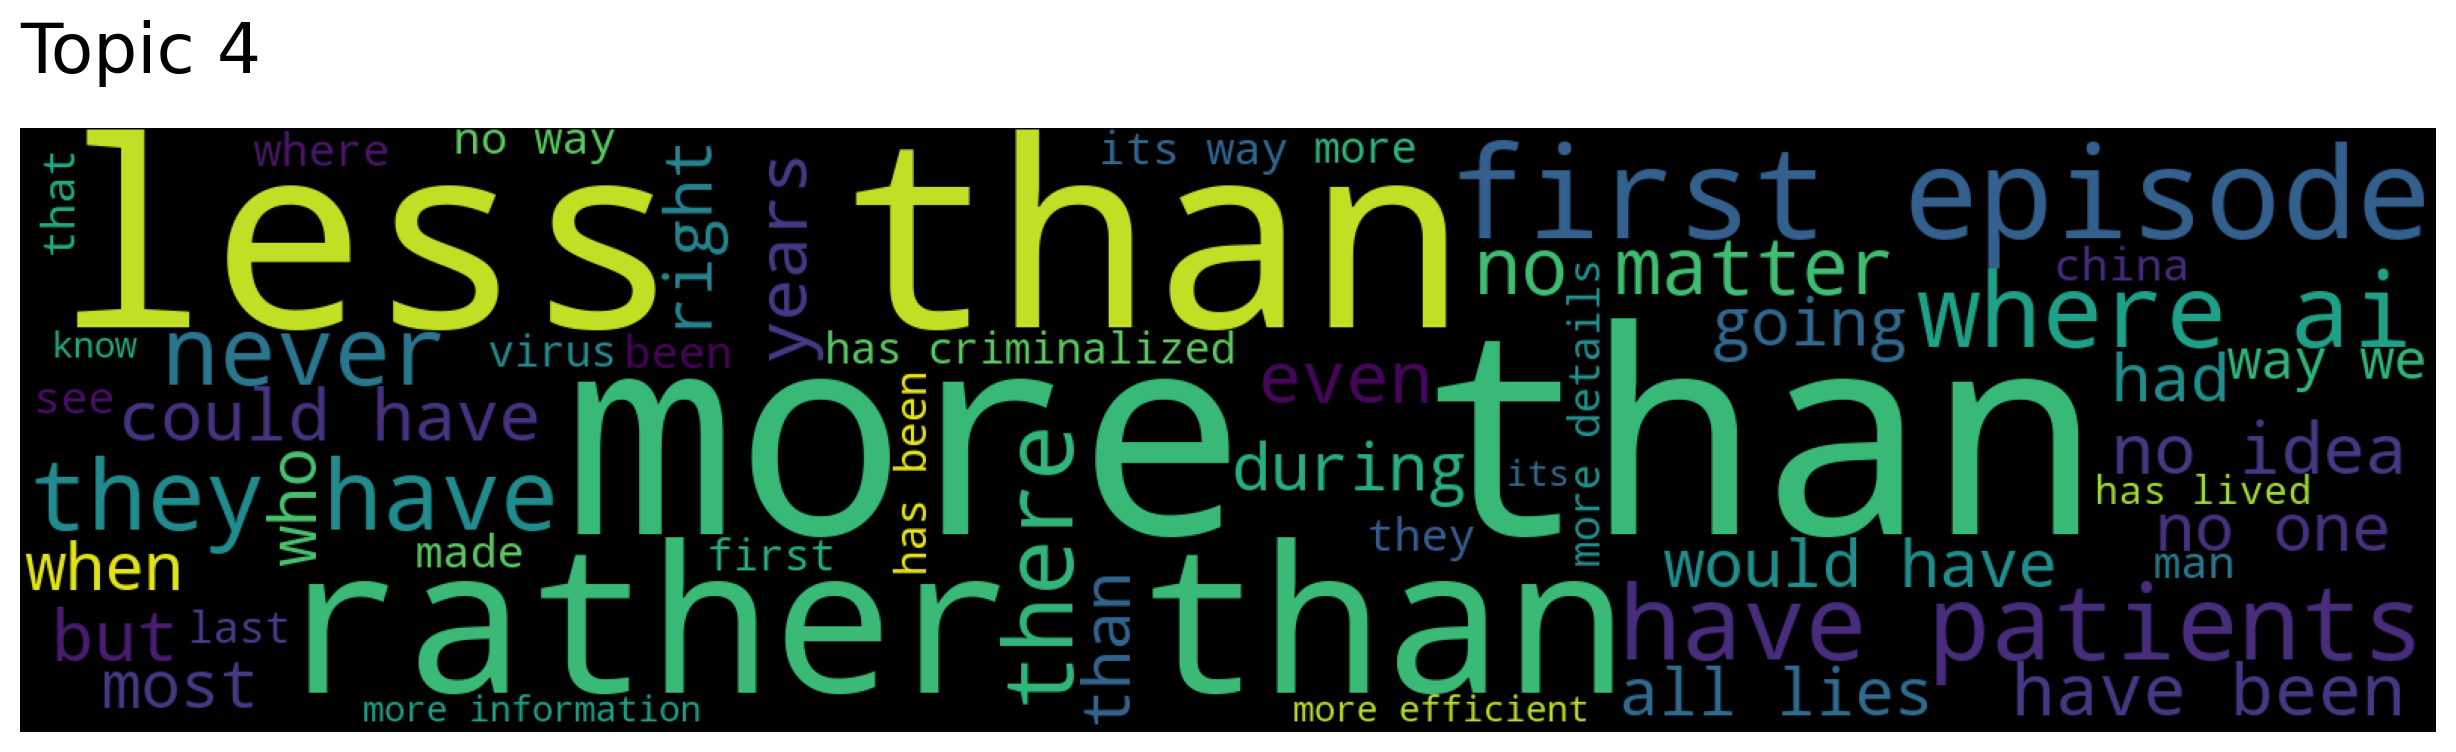

In [40]:
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

**Getting the topics for document(s)**

Get document topics.

The topic of each document will be returned.

The corresponding original topics are returned unless reduced=True,
in which case the reduced topics will be returned.

In [49]:
doc_topics, doc_dist, topic_words, topic_word_scores = model.get_documents_topics(doc_ids=[0,17],num_topics=5)

In [50]:
featured_data.text[:2].tolist()

['"Ah, yes. I just love waking up to the sweet aroma of political chaos and corruption in the morning. It\'s like a breath of fresh air...if that air was filled with hot garbage." #politics #sarcasm',
 'When @ViolavonCramon\nflies to Georgia 🇬🇪 to take part in a protest to support a person accused of using molotov cocktails against the police, who pays her expenses?\n\n#100corruptMEPs\n#zombieNGOs #Corruption\n\n@KubiliusA\n@shpapuashvili\n@AnnaFotyga_PE \n\nhttps://t.co/bS4NsgewiK']

In [51]:
for doc_topic, dist, topic_word, topic_word_score in zip(doc_topics, doc_dist, topic_words, topic_word_scores):
    print(f"Topic number: {doc_topic}\nDocument distribution: {dist}\nTopic words: \n{topic_word}\n")
    print("----------")

Topic number: [33 10  9 11 18]
Document distribution: [0.67373735 0.643001   0.48158094 0.4057607  0.39663985]
Topic words: 
[['chelsea manager' 'at am' 'politics without' 'anyone who' 'who bought'
  'those who' 'via nyt' 'via namo' 'just yesterday' 'love'
  'inscription just' 'via breitbartnews' 'would be' 'champions league'
  'premier league' 'as part' 'india' 'last night' 'daddy' 'future of'
  'last week' 'pitch pm' 'be used' 'pm modi' 'without' 'used to'
  'as well' 'at pm' 'dynastic politics' 'modern politics' 'would have'
  'as we' 'life' 'communist party' 'indian politics' 'such as' 'know it'
  'issue based' 'via youtube' 'graham' 'politics' 'football league'
  'well as' 'last' 'based on' 'even' 'van drew' 'potter' 'league' 'after']
 ['politics without' 'daddy' 'politics daddy' 'without' 'love'
  'sugar daddy' 'make money' 'make move' 'yes daddy' 'daddy of'
  'bitterness daddy' 'make sure' 'big' 'daddy yes' 'competence daddy'
  'used to' 'they were' 'based' 'be used' 'anyone who